# Setup

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pyswarms as ps
import glob
import os
import importlib
import matplotlib.animation as animation

from scipy.io import mmread
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.spatial.distance import cdist
from pyswarms.utils.plotters.formatters import Mesher, Designer
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
from pyswarms.utils.functions import single_obj as fx
from functools import partial
from IPython.display import HTML

import src.pbmc_SI as SI
importlib.reload(SI)

<module 'src.pbmc_SI' from 'd:\\Luca\\Documents\\GitHub\\BDA-project\\notebooks\\src\\pbmc_SI.py'>

# Import data

In [256]:
# ----------------------------------------
# 1. Load PCA and t-SNE Projections
# ----------------------------------------
pca_df = pd.read_csv("data/pbmc10k/analysis/pca/10_components/projection.csv")
tsne_df = pd.read_csv("data/pbmc10k/analysis/tsne/2_components/projection.csv")

# ----------------------------------------
# 2. Load Each K-Means Clustering File
# ----------------------------------------
cluster_files = sorted(glob.glob("data/pbmc10k/analysis/clustering/*_clusters/clusters.csv"))

In [257]:
print(pca_df.shape)
pca_df.head()

(10985, 11)


,Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,AAACCCAGTATATGGA-1,-26.557559,43.616249,-5.920331,-0.437746,-0.684416,-1.070254,7.733377,-3.695116,0.180773,-1.931261
1,AAACCCAGTATCGTAC-1,2.446631,12.503169,9.143050,9.718873,-12.255868,-10.613059,17.103341,-0.873115,-1.452727,4.053146
2,AAACCCAGTCGGTGAA-1,-17.492857,-3.720638,-4.075000,4.693626,-0.223228,-2.966088,2.342027,3.268955,-1.077013,-4.942833
3,AAACCCAGTTAGAAAC-1,33.200922,1.940326,2.890780,3.308408,1.351145,0.437567,-1.220305,6.342324,-0.523541,-0.669859
4,AAACCCAGTTATCTTC-1,-11.462730,15.112253,-44.266984,-10.708478,10.581556,0.123756,-9.832545,1.948709,-4.145212,13.472980


In [258]:
print(tsne_df.shape)
tsne_df.head()

(10985, 3)


,Barcode,TSNE-1,TSNE-2
0,AAACCCAGTATATGGA-1,-45.109948,-18.605584
1,AAACCCAGTATCGTAC-1,8.243309,15.607494
2,AAACCCAGTCGGTGAA-1,-10.061613,-10.863419
3,AAACCCAGTTAGAAAC-1,20.417582,-4.917668
4,AAACCCAGTTATCTTC-1,-32.346937,-27.573911


In [259]:
clusters_df = pd.read_csv("data/pbmc10k/analysis/clustering/graphclust/clusters.csv")
print(clusters_df.shape)
clusters_df.head()

(10985, 2)


,Barcode,Cluster
0,AAACCCAGTATATGGA-1,5
1,AAACCCAGTATCGTAC-1,9
2,AAACCCAGTCGGTGAA-1,2
3,AAACCCAGTTAGAAAC-1,3
4,AAACCCAGTTATCTTC-1,12


In [260]:
data_tsne = tsne_df.drop(columns=["Barcode"]).values

# Old Analysis

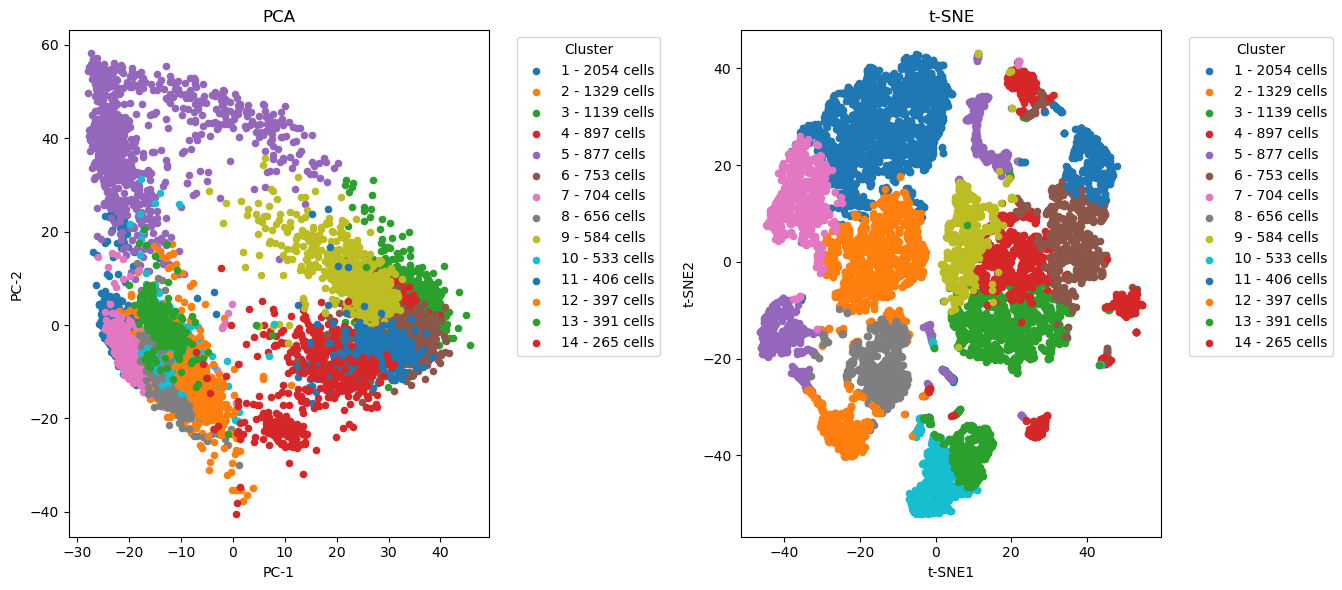

In [261]:
# ----------------------------------------
# 3. Merge with PCA and t-SNE Data
# ----------------------------------------
merged_pca = pd.merge(pca_df, clusters_df, on="Barcode", how="inner")
merged_tsne = pd.merge(tsne_df, clusters_df, on="Barcode", how="inner")

# ----------------------------------------
# 4. Plotting
# ----------------------------------------
# Increase figure width to make images broader
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Use a more distinct categorical palette (e.g., "tab10")
unique_clusters = sorted(merged_pca["Cluster"].unique())
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))

# ---------------------------
# (A) PCA Scatter
# ---------------------------
for i, cluster_label in enumerate(unique_clusters):
    subset = merged_pca[merged_pca["Cluster"] == cluster_label]
    ax[0].scatter(
        subset["PC-1"], 
        subset["PC-2"],
        color=palette[i],
        s=20,
        label=f"{cluster_label} - {len(subset)} cells"
    )

ax[0].set_title("PCA")
ax[0].set_xlabel("PC-1")
ax[0].set_ylabel("PC-2")
ax[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cluster")

# ---------------------------
# (B) t-SNE Scatter
# ---------------------------
for i, cluster_label in enumerate(unique_clusters):
    subset = merged_tsne[merged_tsne["Cluster"] == cluster_label]
    ax[1].scatter(
        subset["TSNE-1"], 
        subset["TSNE-2"],
        color=palette[i],
        s=20,
        label=f"{cluster_label} - {len(subset)} cells"
    )

ax[1].set_title("t-SNE")
ax[1].set_xlabel("t-SNE1")
ax[1].set_ylabel("t-SNE2")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cluster")

# Adjust layout to provide space for legends outside the axes
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [262]:
results = pd.DataFrame(columns=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])
results.loc["K-Means"] = SI.calculate_clustering_scores(data_tsne, clusters_df["Cluster"])
results.head()

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means,0.226,6.889,3255.1


# New Analysis

In [ ]:
# Assume tsne_df is a DataFrame with a 'Barcode' column and two t-SNE coordinate columns.
# Convert tsne_df to a numeric array (ignoring the 'Barcode'):
data_tsne = tsne_df.drop(columns=["Barcode"]).values  # shape: (n_cells, 2)

n_clusters = 14
iters = 100

In [ ]:
n_particles = 30

# Run PSO
start = time.time()
pso_cost, pso_centers, pso_labels, pso_pos_history, pso_cost_history, pso_best_centers_history = SI.run_pso(data_tsne, n_clusters, iters, n_particles = 30, record_history=True)
print("PSO run time: {:.2f} seconds".format(time.time() - start))

results.loc["PSO"] = SI.calculate_clustering_scores(data_tsne, pso_labels)

2025-04-19 17:07:25,964 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2.66e+6
2025-04-19 17:07:31,016 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2657378.9569752035, best pos: [ 21.43967998  -6.0518339  -23.77617652 -15.64086336  28.3537814
  18.88407947 -17.63984329  21.78287851   2.02638079 -39.16753482]


PSO run time: 10.05 seconds


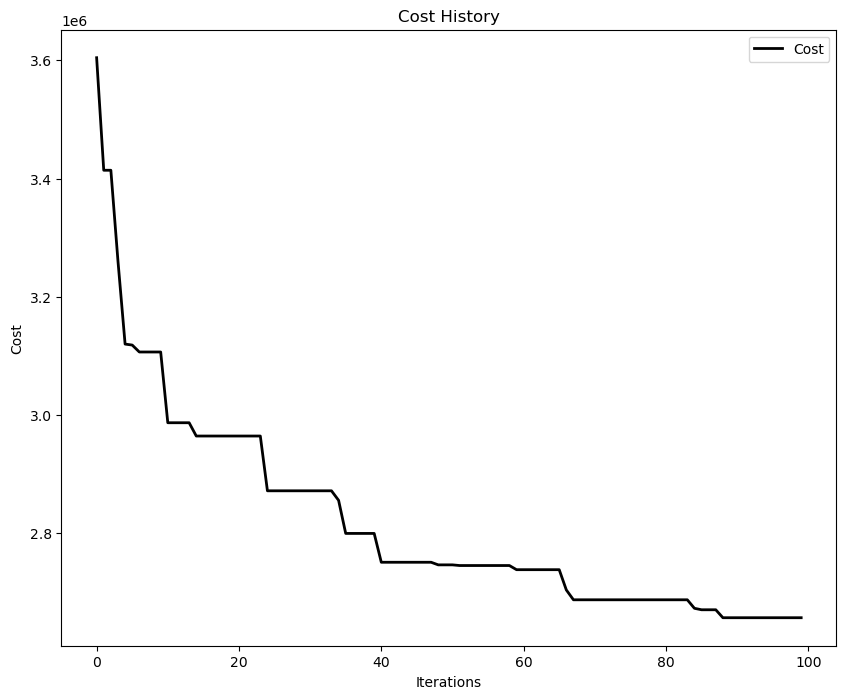

In [265]:
plot_cost_history(cost_history=pso_cost_history)
plt.show()

2025-04-19 17:07:38,355 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-19 17:07:38,357 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


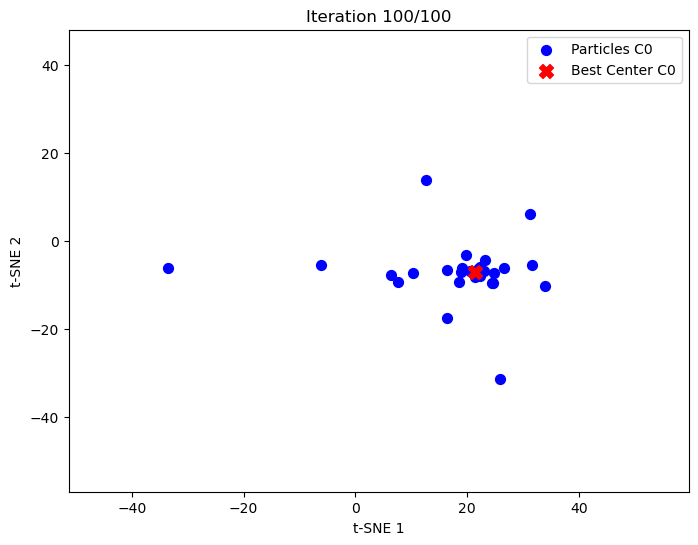

In [266]:
# To animate only cluster #0:
ani0 = SI.animate_best_center_history(data_tsne, pso_pos_history, pso_best_centers_history, center_idx=0)

# Save the animation as a GIF using imagemagick writer
ani0.save('../results/pbmc10k/pso/pso_animation_center0.gif', writer='imagemagick', fps=10)

In [267]:
# Run ABC
start = time.time()
abc_cost, abc_centers, abc_labels, abc_history = SI.run_abc(data_tsne, n_clusters, iters, n_food_sources=30, limit=20, record_history=True)
print("ABC run time: {:.2f} seconds".format(time.time() - start))

results.loc["ABC"] = SI.calculate_clustering_scores(data_tsne, abc_labels)

ABC run time: 6.15 seconds


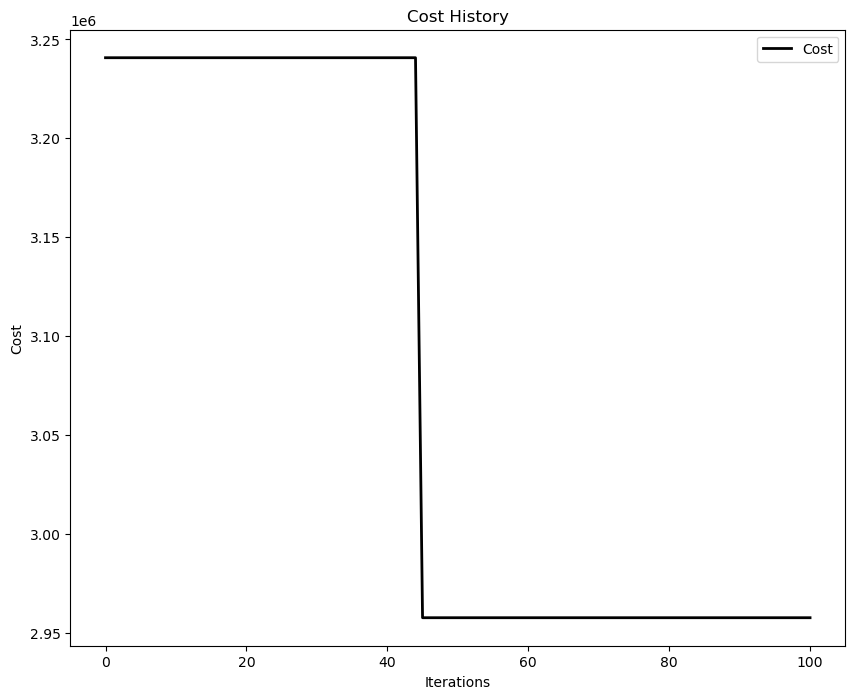

In [268]:
plot_cost_history(cost_history=abc_history["costs"])
plt.show()

2025-04-19 17:08:01,261 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-19 17:08:01,263 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


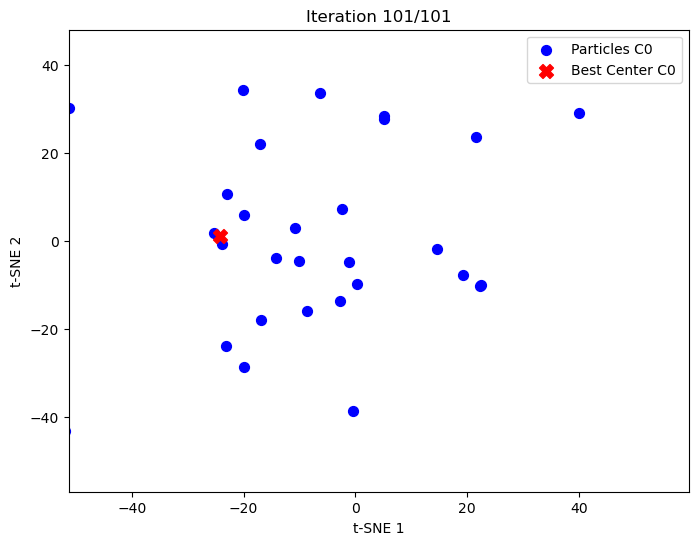

In [269]:
ani0 = SI.animate_best_center_history(data_tsne, abc_history["positions"], abc_history["best_centers"], center_idx=0)
ani0.save('../results/pbmc10k/abc/abc_animation_center0.gif', writer='imagemagick', fps=10)

In [270]:
# Run ACOR (ACO variant)
start = time.time()
acor_cost, acor_centers, acor_labels, acor_history = SI.run_acor(data_tsne, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True)
print("ACOR run time: {:.2f} seconds".format(time.time() - start))

results.loc["ACOR"] = SI.calculate_clustering_scores(data_tsne, acor_labels)

ACOR run time: 4.98 seconds


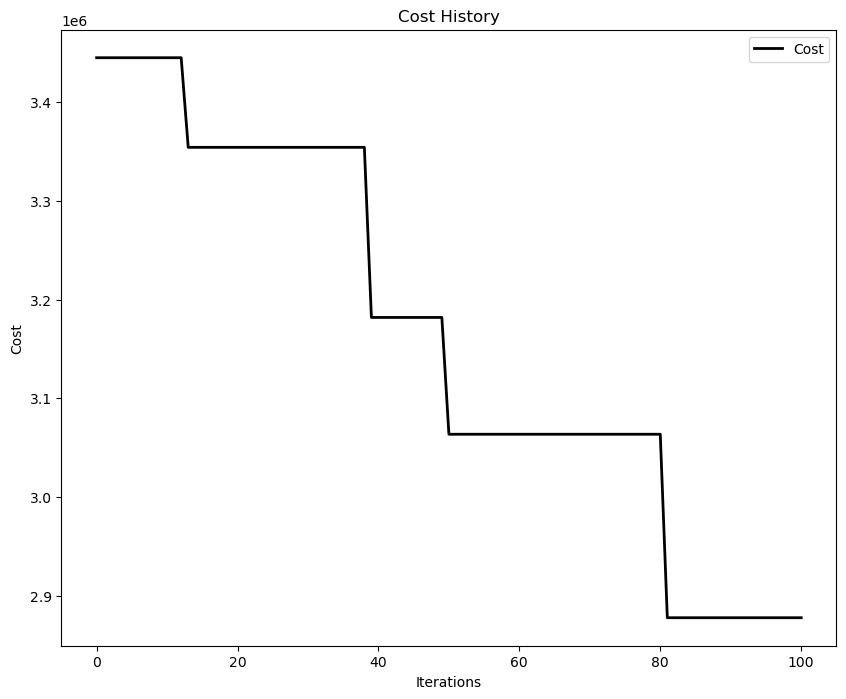

In [271]:
plot_cost_history(cost_history=acor_history["costs"])
plt.show()

2025-04-19 17:09:43,988 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-19 17:09:43,989 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


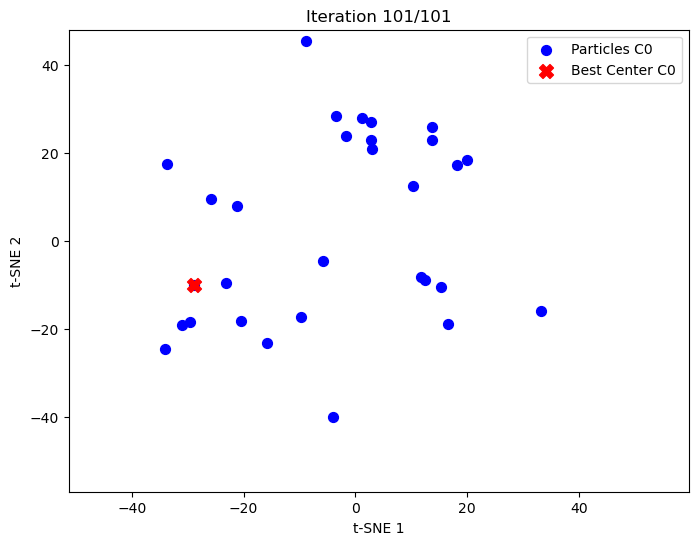

In [274]:
ani = SI.animate_best_center_history(data_tsne, acor_history["archives"], acor_history["best_centers"], center_idx=0)
ani.save('../results/pbmc10k/acor/acor_animation_center0.gif', writer='imagemagick', fps=10)

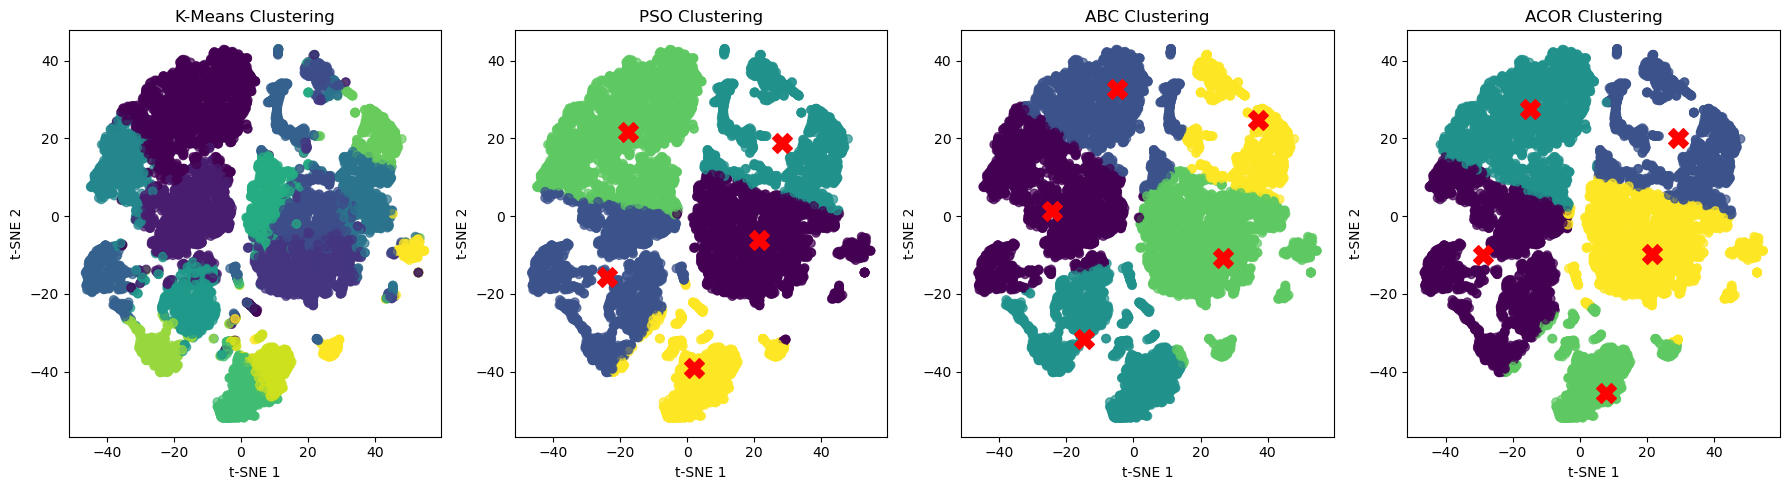

In [275]:
# -------------------------------
# 6. Visualization of Clustering Results
# -------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
SI.plot_clusters(data_tsne, clusters_df["Cluster"], title="K-Means Clustering")

plt.subplot(1, 4, 2)
SI.plot_clusters(data_tsne, pso_labels, title="PSO Clustering", centers=pso_centers)

plt.subplot(1, 4, 3)
SI.plot_clusters(data_tsne, abc_labels, title="ABC Clustering", centers=abc_centers)

plt.subplot(1, 4, 4)
SI.plot_clusters(data_tsne, acor_labels, title="ACOR Clustering", centers=acor_centers)

plt.tight_layout()
plt.show()

In [276]:
# Save clustering results to CSV files
results.to_csv("../results/pbmc10k/clustering_results.csv", index=True)
results.head()

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means,0.226,6.889,3255.1
PSO,0.384,0.895,9768.0
ABC,0.366,0.879,9561.2
ACOR,0.372,0.890,9467.2
